In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
# for neural net
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# for evaluation
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv("data/combined_expression.csv")
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,2,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,1,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,1,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,1,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,1,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [3]:
data.shape

(541, 16384)

In [5]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))

In [6]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)

# Confusion Matrix Plotting Function

In [7]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# 4 Hidden Layers (with batch normalization)

In [14]:
def create_model(optimizer='adam', init='normal', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)

    # first hidden layer
    model.add(Dense(hidden_layers, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    # second hidden layer
    model.add(Dense((hidden_layers*1.5), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    # third hidden layer
    model.add(Dense((hidden_layers), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    # fourth hidden layer
    model.add(Dense((hidden_layers*0.25), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# parameters selected from previous gridsearch
model4 = KerasClassifier(build_fn=hidden4, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [16]:
history4 = model4.fit(X_train, y_train, validation_data=(X_test,y_test), shuffle=True)
y_pred4 = model4.predict(X_test)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 5s 10ms/sample - loss: 0.5232 - accuracy: 0.7662 - val_loss: 0.6350 - val_accuracy: 0.3853
Epoch 2/50
432/432 [==============================] - 0s 797us/sample - loss: 0.3415 - accuracy: 0.8588 - val_loss: 0.6480 - val_accuracy: 0.2752
Epoch 3/50
432/432 [==============================] - 0s 796us/sample - loss: 0.2623 - accuracy: 0.9005 - val_loss: 0.6602 - val_accuracy: 0.1009
Epoch 4/50
432/432 [==============================] - 0s 762us/sample - loss: 0.2312 - accuracy: 0.9190 - val_loss: 0.6507 - val_accuracy: 0.0367
Epoch 5/50
432/432 [==============================] - 0s 770us/sample - loss: 0.1978 - accuracy: 0.9375 - val_loss: 0.5988 - val_accuracy: 0.0550
Epoch 6/50
432/432 [==============================] - 0s 794us/sample - loss: 0.2044 - accuracy: 0.9306 - val_loss: 0.5599 - val_accuracy: 0.0642
Epoch 7/50
432/432 [==============================] - 0s 777us/sample - loss: 0

In [17]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           1       0.87      0.89      0.88        70
           2       0.79      0.77      0.78        39

    accuracy                           0.84       109
   macro avg       0.83      0.83      0.83       109
weighted avg       0.84      0.84      0.84       109



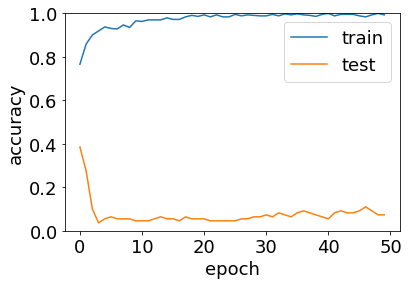

In [18]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0, 1)
plt.show()

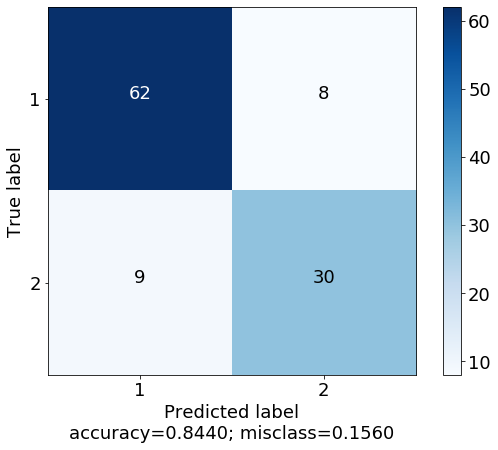

In [19]:
cm = confusion_matrix(y_test, y_pred4)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [114]:
model4.model.save('models/hidden4.h5')

# 3 Hidden Layers

In [21]:
def hidden3(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(BatchNormalization())
    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(BatchNormalization())
    model.add(Dense((hidden_layers*1), activation='relu'))
    model.add(Dropout(dropout))

    model.add(BatchNormalization())
    model.add(Dense((hidden_layers*0.5), activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# parameters selected from previous gridsearch
model3 = KerasClassifier(build_fn=hidden3, epochs=50, batch_size=64, optimizer='adam', init='normal')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [23]:
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred3 = model3.predict(X_test)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 4s 8ms/sample - loss: 0.4614 - accuracy: 0.8194 - val_loss: 1.0212 - val_accuracy: 0.0092
Epoch 2/50
432/432 [==============================] - 0s 546us/sample - loss: 0.3684 - accuracy: 0.8588 - val_loss: 0.7367 - val_accuracy: 0.0092
Epoch 3/50
432/432 [==============================] - 0s 502us/sample - loss: 0.2480 - accuracy: 0.8981 - val_loss: 0.4560 - val_accuracy: 0.1284
Epoch 4/50
432/432 [==============================] - 0s 573us/sample - loss: 0.2365 - accuracy: 0.9005 - val_loss: 0.3829 - val_accuracy: 0.1376
Epoch 5/50
432/432 [==============================] - 0s 442us/sample - loss: 0.1784 - accuracy: 0.9282 - val_loss: 0.2693 - val_accuracy: 0.2477
Epoch 6/50
432/432 [==============================] - 0s 457us/sample - loss: 0.1263 - accuracy: 0.9630 - val_loss: 0.1565 - val_accuracy: 0.4128
Epoch 7/50
432/432 [==============================] - 0s 416us/sample - loss: 0.

In [24]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           1       0.91      0.89      0.90        70
           2       0.80      0.85      0.83        39

    accuracy                           0.87       109
   macro avg       0.86      0.87      0.86       109
weighted avg       0.87      0.87      0.87       109



In [25]:
print(confusion_matrix(y_test, y_pred3))

[[62  8]
 [ 6 33]]


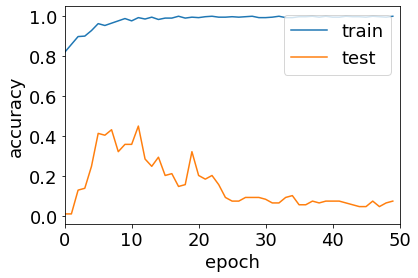

In [26]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim(0, 50)
plt.show()

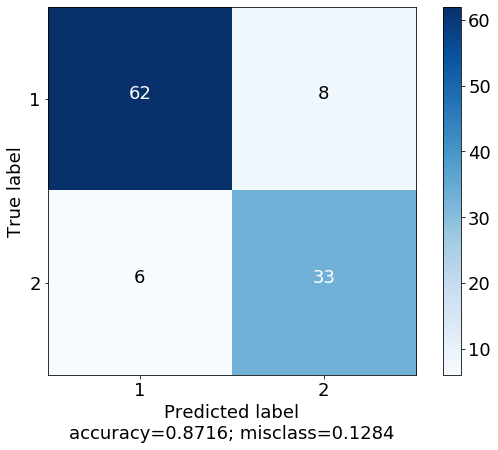

In [27]:
cm = confusion_matrix(y_test, y_pred3)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [ ]:
model3.model.save('models/hidden3.h5')

# 2 Hidden Layers

In [147]:
def hidden2(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense((hidden_layers), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(3, activation='softmax'))
    # compiling
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [148]:
# parameters selected from previous gridsearch
model2 = KerasClassifier(build_fn=hidden2, epochs=75, batch_size=64, optimizer='Adagrad',init='uniform')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [149]:
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred2 = model2.predict(X_test)

Train on 432 samples, validate on 109 samples
Epoch 1/75
432/432 [==============================] - 2s 4ms/sample - loss: 1.3817 - accuracy: 0.4421 - val_loss: 7.7001 - val_accuracy: 0.6422
Epoch 2/75
432/432 [==============================] - 0s 286us/sample - loss: 1.1376 - accuracy: 0.5509 - val_loss: 7.7828 - val_accuracy: 0.3945
Epoch 3/75
432/432 [==============================] - 0s 280us/sample - loss: 0.9973 - accuracy: 0.6134 - val_loss: 7.8597 - val_accuracy: 0.2936
Epoch 4/75
432/432 [==============================] - 0s 283us/sample - loss: 0.8847 - accuracy: 0.6481 - val_loss: 7.9480 - val_accuracy: 0.2569
Epoch 5/75
432/432 [==============================] - 0s 282us/sample - loss: 0.8756 - accuracy: 0.6296 - val_loss: 7.9803 - val_accuracy: 0.2018
Epoch 6/75
432/432 [==============================] - 0s 308us/sample - loss: 0.8004 - accuracy: 0.6968 - val_loss: 8.0103 - val_accuracy: 0.1927
Epoch 7/75
432/432 [==============================] - 0s 284us/sample - loss: 0.

In [150]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           1       0.50      0.56      0.53        27
           2       0.68      0.76      0.72        25
           3       0.78      0.70      0.74        57

    accuracy                           0.68       109
   macro avg       0.65      0.67      0.66       109
weighted avg       0.69      0.68      0.68       109



In [151]:
print(confusion_matrix(y_test, y_pred2))

[[15  3  9]
 [ 4 19  2]
 [11  6 40]]


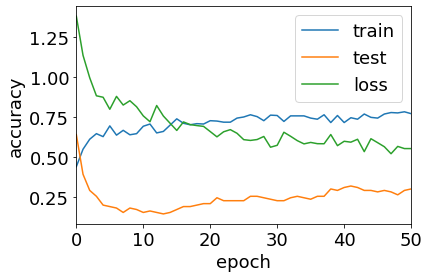

In [152]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim(0, 50)
plt.show()

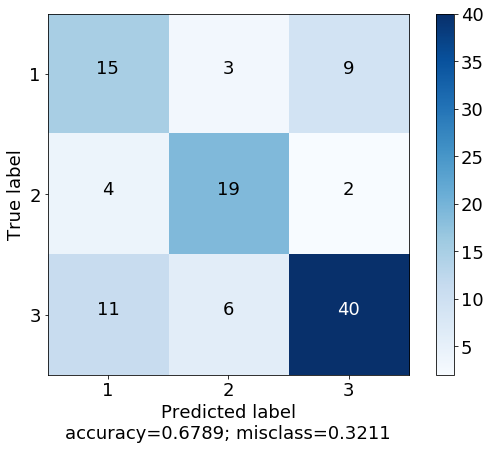

In [153]:
cm = confusion_matrix(y_test, y_pred2)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2', '3'], title='', normalize=False)

In [ ]:
model2.model.save('models/hidden2.h5')

# 1 Hidden Layer

In [ ]:
def hidden1(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='softmax'))
    # compiling
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# parameters selected from previous gridsearch
model1 = KerasClassifier(build_fn=hidden1, epochs=50, batch_size=16, optimizer='Adam',init='uniform')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred1 = model1.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred1))

In [ ]:
print(confusion_matrix(y_test, y_pred1))

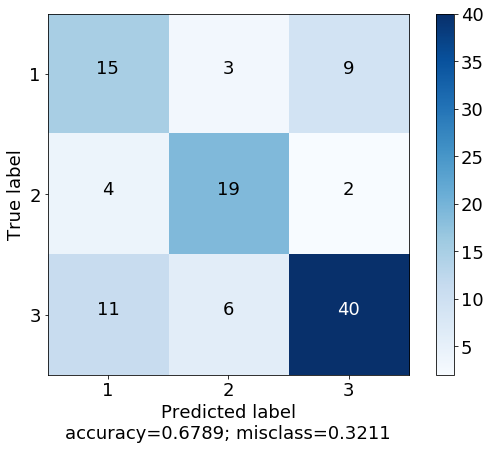

In [153]:
cm = confusion_matrix(y_test, y_pred1)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2', '3'], title='', normalize=False)

In [ ]:
model1.model.save('models/hidden1.h5')